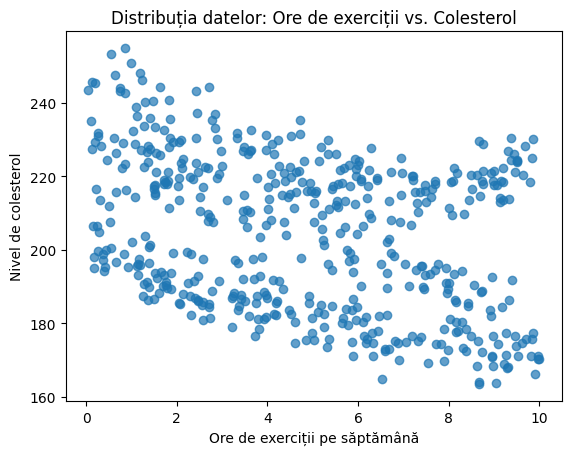

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Încarcăm datele (simulat după descriere)
data = pd.read_csv("date_colesterol.csv")

# Vizualizăm datele
plt.scatter(data['Ore_Exercitii'], data['Colesterol'], alpha=0.7)
plt.title("Distribuția datelor: Ore de exerciții vs. Colesterol")
plt.xlabel("Ore de exerciții pe săptămână")
plt.ylabel("Nivel de colesterol")
plt.show()


In [5]:
# Definim funcția pentru a estima un model GMM și a ajusta regresii
def fit_gmm_regression(data, K):
    X = data['Ore_Exercitii'].values.reshape(-1, 1)
    y = data['Colesterol'].values

    # Ajustăm modelul de mixtură Gaussiana
    gmm = GaussianMixture(n_components=K, random_state=42)
    gmm.fit(np.column_stack((X, y)))
    labels = gmm.predict(np.column_stack((X, y)))

    # Estimăm regresii polinomiale pentru fiecare subgrup
    models = []
    for k in range(K):
        subgroup_idx = labels == k
        X_subgroup = X[subgroup_idx]
        y_subgroup = y[subgroup_idx]

        # Regresie polinomială de gradul 2
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(X_subgroup)
        model = LinearRegression().fit(X_poly, y_subgroup)
        models.append((model, poly))

    return gmm, models, labels

# Aplicăm pentru fiecare K
Ks = [3, 4, 5]
gmm_models = {}
regression_models = {}

for K in Ks:
    gmm, models, labels = fit_gmm_regression(data, K)
    gmm_models[K] = gmm
    regression_models[K] = models


In [6]:
# Funcție pentru calcularea log-likelihood
def calculate_log_likelihood(data, gmm, models):
    X = data['Ore_Exercitii'].values.reshape(-1, 1)
    y = data['Colesterol'].values

    log_likelihood = 0
    for k, (model, poly) in enumerate(models):
        X_poly = poly.transform(X)
        mean = model.predict(X_poly)
        variance = gmm.covariances_[k, 1, 1]
        log_likelihood += gmm.weights_[k] * np.exp(-0.5 * ((y - mean)**2) / variance) / np.sqrt(2 * np.pi * variance)

    return np.log(log_likelihood)

# Calculăm WAIC și LOO
waic_scores = {}
loo_scores = {}

for K in Ks:
    log_likelihood = calculate_log_likelihood(data, gmm_models[K], regression_models[K])
    waic = -2 * np.mean(log_likelihood)  # WAIC formula simplificată
    loo = -2 * np.sum(log_likelihood)   # LOO bazat pe log-likelihood
    waic_scores[K] = waic
    loo_scores[K] = loo


In [7]:
# Afișăm rezultatele
print("WAIC scores:", waic_scores)
print("LOO scores:", loo_scores)

# Determinăm modelul optim
best_K_waic = min(waic_scores, key=waic_scores.get)
best_K_loo = min(loo_scores, key=loo_scores.get)

print(f"Cel mai bun model conform WAIC: {best_K_waic} subpopulații")
print(f"Cel mai bun model conform LOO: {best_K_loo} subpopulații")


WAIC scores: {3: 8.663839038208444, 4: 8.575284081282815, 5: 8.754808958257518}
LOO scores: {3: 4331.919519104222, 4: 4287.642040641407, 5: 4377.404479128759}
Cel mai bun model conform WAIC: 4 subpopulații
Cel mai bun model conform LOO: 4 subpopulații
